In [5]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install -qU "langchain[openai]"
%pip install -U langchain langchain-openai
%pip install -qU langchain-core

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


In [3]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


In [5]:
loader.__dict__

{'web_paths': ['https://lilianweng.github.io/posts/2023-06-23-agent/'],
 'requests_per_second': 2,
 'default_parser': 'html.parser',
 'requests_kwargs': {},
 'raise_for_status': False,
 'show_progress': True,
 'bs_get_text_kwargs': {},
 'bs_kwargs': {'parse_only': <SoupStrainer name=[] attrs=defaultdict(<class 'list'>, {'class': [<AttributeValueMatchRule string=post-content pattern=None function=None present=None>, <AttributeValueMatchRule string=post-title pattern=None function=None present=None>, <AttributeValueMatchRule string=post-header pattern=None function=None present=None>]}) string=[]>},
 'session': <requests.sessions.Session at 0x107bd9e80>,
 'continue_on_failure': False,
 'autoset_encoding': True,
 'encoding': None,
 'trust_env': False}

In [6]:
print(type(docs), 'Number of char' ,len(docs[0].page_content))

<class 'list'> Number of char 43130


In [7]:
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [ ]:
# select the LLM

In [8]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

# from langchain.chat_models import init_chat_model
# llm = init_chat_model("gpt-4o-mini", model_provider="openai")

Enter API key for OpenAI:  ········


In [ ]:
# for leverage langsmith

In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini",
    temperature=0,
    max_retries=2,)

In [ ]:
# Select the Embeddings

In [10]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [11]:
# Select the vector store

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [14]:
# vector_store.__dict__

In [13]:
help(hub.pull)

Help on function pull in module langchain.hub:

pull(
    owner_repo_commit: 'str',
    *,
    include_model: 'Optional[bool]' = None,
    api_url: 'Optional[str]' = None,
    api_key: 'Optional[str]' = None
) -> 'Any'
    Pull an object from the hub and returns it as a LangChain object.

    :param owner_repo_commit: The full name of the prompt to pull from in the format of
        `owner/prompt_name:commit_hash` or `owner/prompt_name`
        or just `prompt_name` if it's your own prompt.
    :param api_url: The URL of the LangChain Hub API. Defaults to the hosted API service
        if you have an api key set, or a localhost instance if not.
    :param api_key: The API key to use to authenticate with the LangChain Hub API.



In [14]:

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


In [29]:
# this particular prompt from the hub, is defining the variables Question: {question} Context: {context}  in its prompt

In [15]:

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


In [16]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [17]:
type(graph),  type(graph_builder)

(langgraph.graph.state.CompiledStateGraph, langgraph.graph.state.StateGraph)

In [31]:
# help(StateGraph)

In [18]:
# API Reference:hub | WebBaseLoader | Document | RecursiveCharacterTextSplitter | StateGraph

In [18]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is the process of breaking down a complex task into smaller, more manageable steps. This can be achieved through techniques like Chain of Thought (CoT) and Tree of Thoughts, which guide models to think step by step and explore multiple reasoning possibilities. It allows for better planning and execution by clarifying the logical relationships between tasks.


In [19]:
response = graph.invoke({"question": "Summarize the topics being discussed, and mention 3 important points from each topic"})
print(response["answer"])

The conversation discusses the development of a Super Mario game in Python, focusing on the MVC architecture and keyboard controls. 

**Important points:**
1. The game will be structured using MVC components, which need to be split into separate files.
2. Clarification is needed on the specifics of the game, including level design, characters, and gameplay mechanics.
3. Details regarding the implementation of keyboard controls, such as key mappings and input handling, are also required.


<h1> PART 2 </h1>

In [20]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [26]:
type(retrieve)

langchain_core.tools.structured.StructuredTool

<p>
new steps in the graph, 

query or respond : will bind the model with the retrieve tool
    and gets relavant docs using the messages in state
    and then appends the results to messages
</p>

In [24]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [47]:
# help(MessagesState)

In [25]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

<p> 
ToolNode does the following:
Creates a graph that works with a chat model that utilizes tool calling. 
</p>

<h2> Building a graph to specify the order of steps </h2>

In [27]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

<h3> visualize the graph </h3>

In [30]:
type(graph)

langgraph.graph.state.CompiledStateGraph

In [31]:
type(graph.get_graph())

langchain_core.runnables.graph.Graph

In [33]:
from langchain_core.runnables.graph import Graph as gph

In [44]:
# help(gph)

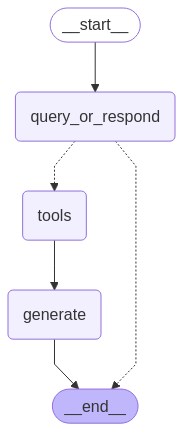

In [35]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

<h1> run </h1>

In [28]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [29]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Vi6UXKFEbDdo6RSyMZBsnVqC)
 Call ID: call_Vi6UXKFEbDdo6RSyMZBsnVqC
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms b

<h1> Adding persistance usign langGraph to our model </h1>

<p>
The main thing is using checkpointers, which are essentially saving memory during each step.
</p>

In [37]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [39]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task Decomposition is the process of breaking down a complex task into smaller, more manageable components or steps. This technique is often used in various fields, including artificial intelligence and project management, to simplify problem-solving and enhance understanding.

In the context of AI, particularly with large language models (LLMs), Task Decomposition can involve prompting the model to think step by step, allowing it to tackle difficult tasks more effectively. This method can be implemented through various strategies, such as:

1. **Chain of Thought (CoT)**: A prompting technique that encourages the model to articulate its reasoning process step by step.
2. **Tree of Thoughts**: An extension of CoT that explores multiple reasoning possibilities at each step, creating a tree structure

In [40]:
input_message = "As a programmer or engineer what do i need to I need to know if I were to use Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

As a programmer or engineer what do i need to I need to know if I were to use Task Decomposition?
================================== Ai Message ==================================

If you're a programmer or engineer looking to use Task Decomposition, here are some key points and considerations to keep in mind:

1. **Understanding the Problem**:
   - Clearly define the overall task or problem you are trying to solve.
   - Identify the goals and desired outcomes of the task.

2. **Breaking Down the Task**:
   - Divide the main task into smaller, manageable sub-tasks or components.
   - Ensure that each sub-task is specific, actionable, and can be completed independently.

3. **Prioritization**:
   - Determine the order in which the sub-tasks should be completed.
   - Identify dependencies between tasks to understand which tasks must be completed before others.

4. **Use of Prompts and Techniques**:
   - Fami

<h1> 
Agents using a tool
</h1>

In [42]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

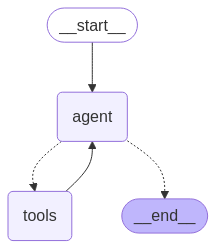

In [43]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

<p>
The key difference from our earlier implementation is that instead of a final generation step that ends the run, here the tool invocation loops back to the original LLM call. The model can then either answer the question using the retrieved context, or generate another tool call to obtain more information.

</p>

In [45]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_3TY3VZ4C0sybPk5cA3L1biNv)
 Call ID: call_3TY3VZ4C0sybPk5cA3L1biNv
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majori